In [ ]:
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+

In [7]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
EXPECTED_N = 20000

In [26]:
def simulator(z):
    return np.array([z[0],2*(z[1]-z[0])])

def noise(x, z = None, noise=0.01):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.55,0.45])
zdim = len(z0)
x0 = simulator(z0)  # Using Asimov data

In [27]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


In [28]:
intensity = None

for _ in range(2):
    if intensity is None:
        intensity = swyft.get_unit_intensity(expected_n=EXPECTED_N, dim=zdim)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
            #factor_mask=intensity.factor_mask,
        )
    cache.grow(intensity)
    cache.simulate(simulator)
    points = swyft.Points(cache, intensity, noise)
    re = swyft.RatioEstimator(points, device=DEVICE)
    re.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

Simulate:   1%|▏         | 266/19887 [00:00<00:07, 2656.58it/s]

Adding 19887 new samples. Run simulator!


Simulate: 100%|██████████| 19887/19887 [00:05<00:00, 3453.56it/s]


yshape (shape of features between head and legs): 2
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 80.74855428934097
Validation loss: 59.78866225481033
Validation loss: 66.97459495067596
Total epochs: 3
LR iteration 1
Validation loss: 56.64806129038334
Validation loss: 56.41669337451458
Validation loss: 53.38237398862839
Validation loss: 55.69563207030296
Total epochs: 4
LR iteration 2
Validation loss: 50.26532216370106
Validation loss: 48.61573867499828
Validation loss: 49.14072297513485
Total epochs: 3


Simulate:   2%|▏         | 365/19685 [00:00<00:05, 3649.26it/s]

Constrained posterior area: 0.010574995940575255
Adding 19685 new samples. Run simulator!


Simulate: 100%|██████████| 19685/19685 [00:05<00:00, 3697.64it/s]


yshape (shape of features between head and legs): 2
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 249.718647480011
Validation loss: 240.56396174430847
Validation loss: 219.6198751926422
Validation loss: 208.3175299167633
Validation loss: 208.70759773254395
Total epochs: 5
LR iteration 1
Validation loss: 204.41070246696472
Validation loss: 201.47641277313232
Validation loss: 198.50708079338074
Validation loss: 195.90004694461823
Validation loss: 203.937566280365
Total epochs: 5
LR iteration 2
Validation loss: 194.1607494354248
Validation loss: 193.83594274520874
Validation loss: 198.61688113212585
Total epochs: 3


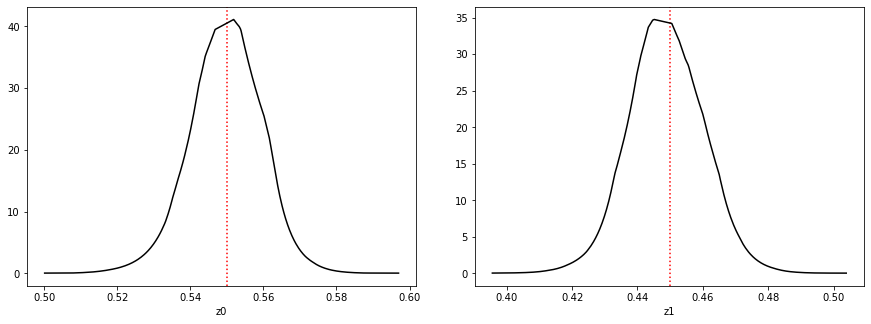

In [29]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys')

In [30]:
re2 = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
re2.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 2
Start training
LR iteration 0
Validation loss: 52.19612981379032
Validation loss: 55.09544947743416
Total epochs: 2
LR iteration 1
Validation loss: 40.12826035916805
Validation loss: 42.59993401169777
Total epochs: 2
LR iteration 2
Validation loss: 40.12063875794411
Validation loss: 42.59800988435745
Total epochs: 2


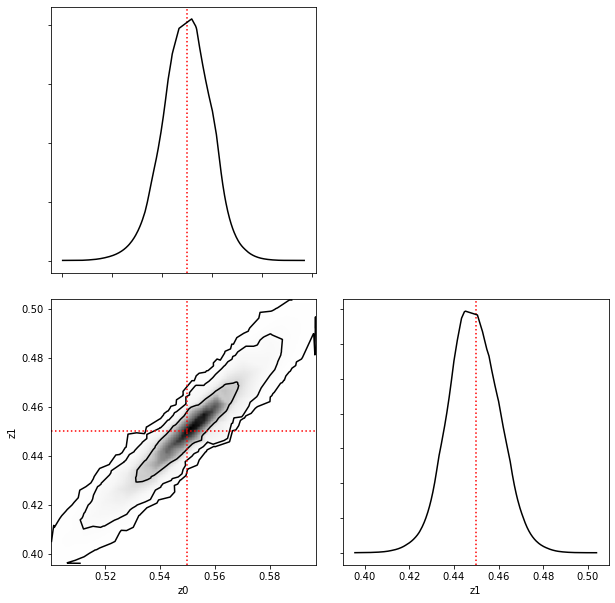

In [31]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 10)